In [1]:
import numpy as np
import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from glob import glob
import os
import random
from skimage import color
import cv2
from tqdm import tqdm 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [201]:
N_CLASSES = 6
n_epochs = 10
batch_size_train = 32
batch_size_test = 32
learning_rate = 0.01
momentum = 0.5
log_interval = 5
device = torch.device('cuda')
image_size = (224, 224)

random_seed = 1
torch.manual_seed(random_seed)

In [202]:
ls 'gdrive/MyDrive/JOURNAL_HCR_PROJECT/Grades Dataset/'

Test/  Train/


In [203]:
TRAIN_DATA_PATH = 'gdrive/MyDrive/JOURNAL_HCR_PROJECT/Grades Dataset/Train'
TEST_DATA_PATH = 'gdrive/MyDrive/JOURNAL_HCR_PROJECT/Grades Dataset/Test'

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])

In [204]:
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_loader = data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True,  num_workers=4) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [205]:
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_loader = data.DataLoader(test_data, batch_size=batch_size_test, shuffle=True,  num_workers=4) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [206]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [207]:
example_data.shape

torch.Size([32, 3, 224, 224])

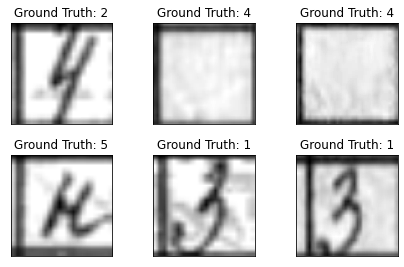

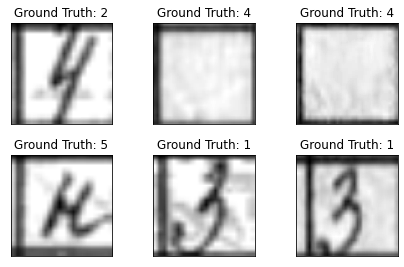

In [208]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [209]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.effnet = torchvision.models.efficientnet_b0(pretrained = True)
        self.l1 = nn.Linear(1000 , 256)
        #self.dropout = nn.Dropout(0.1)
        self.l2 = nn.Linear(1000,N_CLASSES)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.effnet(input)
        x = x.view(x.size(0),-1)
        #x = self.relu(self.l1(x))
        x = self.l2(x)
        return F.log_softmax(x)

In [210]:
network = Net().to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [211]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [212]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = data.to(device)
    target = target.to(device)
    
    output = network(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
  train_losses.append(loss.item())
  train_counter.append(
    (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
  if not os.path.isdir('/content/results'):
    os.mkdir('/content/results')
  torch.save(network.state_dict(), '/content/results/model.pth')
  torch.save(optimizer.state_dict(), '/content/results/optimizer.pth')

In [213]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      target = target.to(device)
      data = data.to(device)
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [214]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Train Epoch: 1 [0/535 (0%)]	Loss: 2.010045
Train Epoch: 1 [160/535 (29%)]	Loss: 17.002174
Train Epoch: 1 [320/535 (59%)]	Loss: 8.067558
Train Epoch: 1 [480/535 (88%)]	Loss: 3.068972


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 5388.6159, Accuracy: 22/252 (9%)

Train Epoch: 2 [0/535 (0%)]	Loss: 1.484407
Train Epoch: 2 [160/535 (29%)]	Loss: 2.305279
Train Epoch: 2 [320/535 (59%)]	Loss: 2.068183
Train Epoch: 2 [480/535 (88%)]	Loss: 1.543066

Test set: Avg. loss: 195.1649, Accuracy: 35/252 (14%)

Train Epoch: 3 [0/535 (0%)]	Loss: 1.116765
Train Epoch: 3 [160/535 (29%)]	Loss: 1.751132
Train Epoch: 3 [320/535 (59%)]	Loss: 0.954838
Train Epoch: 3 [480/535 (88%)]	Loss: 0.944962

Test set: Avg. loss: 0.8178, Accuracy: 180/252 (71%)

Train Epoch: 4 [0/535 (0%)]	Loss: 1.327333
Train Epoch: 4 [160/535 (29%)]	Loss: 1.017132
Train Epoch: 4 [320/535 (59%)]	Loss: 0.337544
Train Epoch: 4 [480/535 (88%)]	Loss: 0.667776

Test set: Avg. loss: 0.1692, Accuracy: 239/252 (95%)

Train Epoch: 5 [0/535 (0%)]	Loss: 0.625410
Train Epoch: 5 [160/535 (29%)]	Loss: 0.283330
Train Epoch: 5 [320/535 (59%)]	Loss: 0.559257
Train Epoch: 5 [480/535 (88%)]	Loss: 0.244514

Test set: Avg. loss: 0.2394, Accuracy: 240/252 (95%)


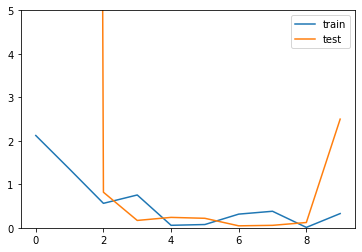

In [215]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')

plt.ylim([0, 5])
plt.legend()
plt.show()

In [216]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [217]:
test()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.4989, Accuracy: 118/252 (47%)



In [218]:
grades_folder_path = 'gdrive/MyDrive/JOURNAL_HCR_PROJECT/postprocessing_data/cutt_result/test4/grades'
labels_mapp = ['2',  '3',  '4',  '5',  'empty',  'н']

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 4 Predict: 4


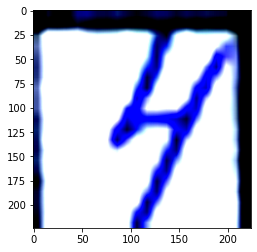

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 3 Predict: 3


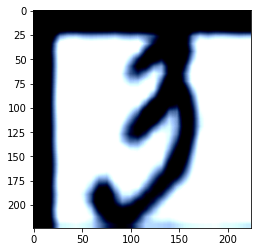

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 4 Predict: 3


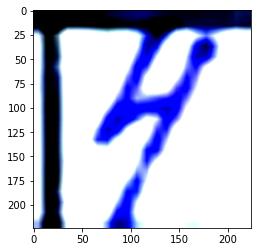

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: н Predict: н


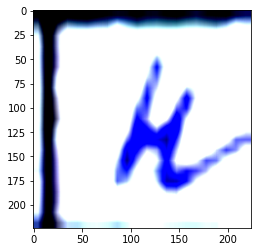

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 4 Predict: 3


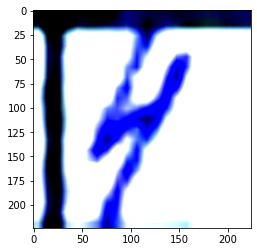

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 2 Predict: 3


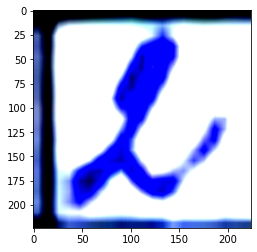

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 4 Predict: 3


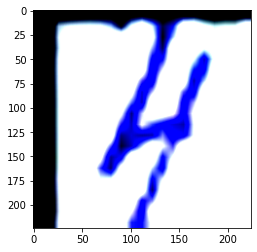

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 4 Predict: 3


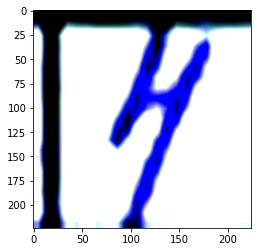

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 4 Predict: 3


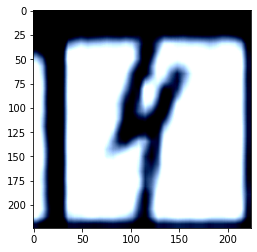

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: empty Predict: н


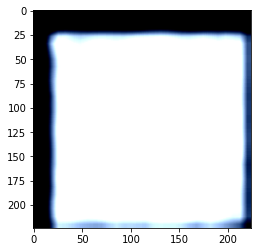

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 4 Predict: 4


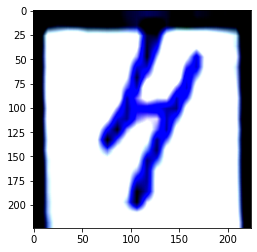

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 4 Predict: 3


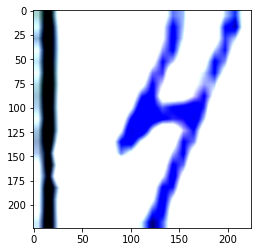

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: н Predict: н


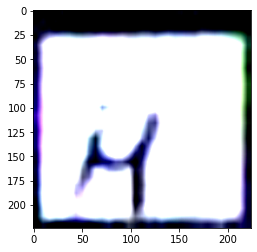

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 4 Predict: 3


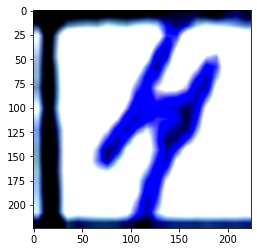

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 4 Predict: 3


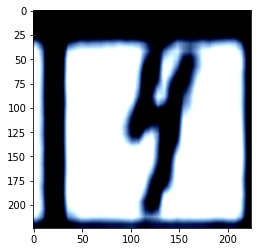

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 4 Predict: 4


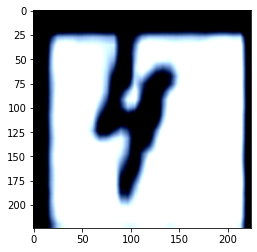

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: н Predict: н


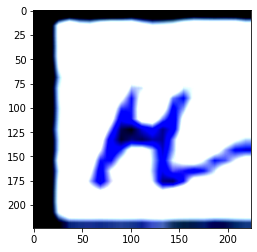

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: н Predict: н


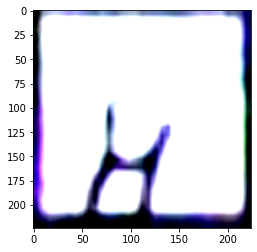

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 4 Predict: 4


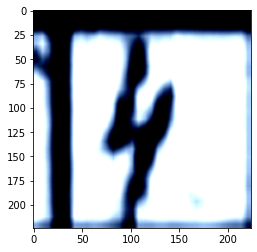

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 4 Predict: 3


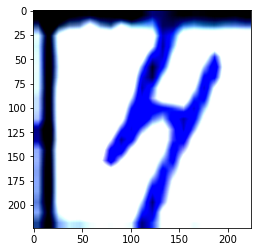

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 4 Predict: 3


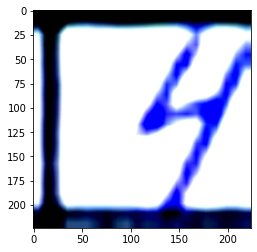

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 4 Predict: 3


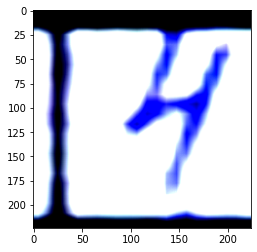

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: н Predict: н


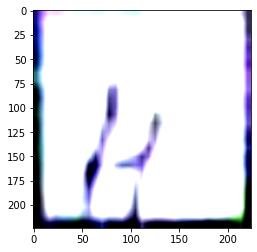

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 4 Predict: 3


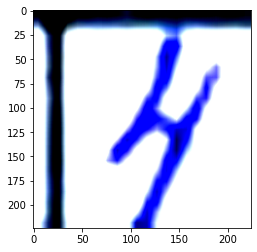

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 3 Predict: 3


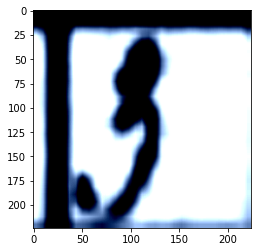

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 4 Predict: 4


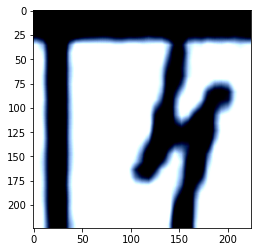

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: empty Predict: н


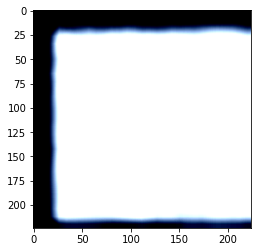

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 4 Predict: 4


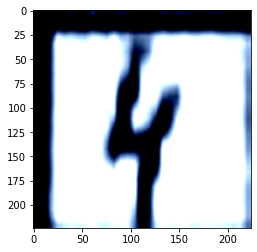

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 4 Predict: 3


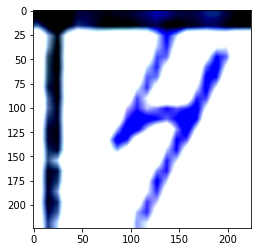

GT: empty Predict: н


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


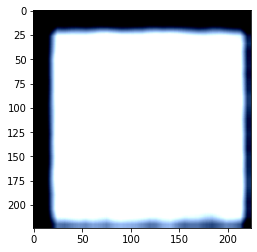

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 4 Predict: 3


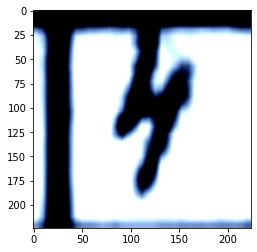

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 4 Predict: 3


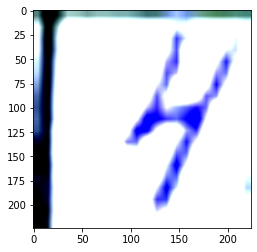

In [219]:
examples = enumerate(test_loader)
_, (example_data, example_targets) = next(examples)

for i in range(len(example_data)):
    test_image = example_data[i]
    gt = example_targets[i]

    network.eval()
    with torch.no_grad():
        test_image = test_image.to(device)
        output = network(test_image.unsqueeze(0))

    pred = output.data.max(1, keepdim=True)[1]
    predict_label = labels_mapp[pred.squeeze().cpu().detach().numpy()]
    print("GT: {} Predict: {}".format(labels_mapp[gt], predict_label))
    plt.imshow(test_image.cpu().detach().numpy().transpose(1,2,0))
    plt.show()

In [65]:
#ls 'gdrive/MyDrive/JOURNAL_HCR_PROJECT/postprocessing_data/cutt_result/test4/grades'